# Capstone Project - The Battle of Neighborhoods - Toronto
### Applied Data Science Capstone by IBM/Coursera

![New York](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Toronto_360_degree_panorama_from_CN_Tower.jpg/1920px-Toronto_360_degree_panorama_from_CN_Tower.jpg)

## Table of contents
* [Introduction and Data description](#introduction)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction and Data description <a name="introduction"></a>
---

### Introduction/Business Problem 
Coffee is a rich source of antioxidants that slow down the aging process of tissues and effectively protect the body against health loss. One cup of coffee has been shown to contain even more antioxidants than a glass of grapefruit, blueberry, raspberry or orange juice. Iwestor already has many cafes of his own brand in the world. Now he intends to conquer a new market. Taking into account the above, the investor intends to open a new cafe in Toronto. Unfortunately, he doesn't know the city well and doesn't know where to open a café. He wants to know if there are coffee shops in all the neighborhoods. **That's why he wants to open a business where there are already cafés but they are not very popular.** As a result, the business problem is: 

   - **Where to open a new a Successful Cafe in Toronto?**

I would like to do some research and recommend them the best place based on the number of cafes in different districts of Toronto. In order to solve this business problem, we intend to merge Toronto districts into a cluster in order to recommend locations. 

### Data
To consider the objective stated above, we can list the below data sources used for the analysis.

* **Districts of Toronto** [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) page was scraped to pull out the necessary information;
* **Coordinate data** for each Districts of Toronto obtained through Nominatim search engine for OpenStreetMap data;

In order to investigate and target recommended locations in different locations depending on the presence of facilities and necessary objects, we will access the data through the **FourSquare API** and arrange it as a data frame for visualization. By combining data about districts in Toronto and data about amenities and essential facilities surrounding such properties from the FourSquare API, we will be able to recommend an appropriate location.

## Methodology <a name="methodology"></a>
---
The methodology in this project consists of two parts:
- **Data Understanding & Data Preparation**: Process of gathering and measuring information on variables of interest, in an established systematic fashion that enables one to answer stated research questions, test hypotheses, and evaluate outcomes.Once the data has been collected, it must be transformed into a useable subset unless it is determined that more data is needed. Once a dataset is chosen, it must then be checked for questionable, missing, or ambiguous cases. 
- **Data Preparation & Data Exploration**: Process of gathering and measuring information on variables of interest, in an established systematic fashion that enables one to answer stated research questions, test hypotheses, and evaluate outcomes.Once the data has been collected, it must be transformed into a useable subset unless it is determined that more data is needed. Once a dataset is chosen, it must then be checked for questionable, missing, or ambiguous cases. It is necessary to visualise the districts of Toronto.
- **Modelling**: To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.

### Data Understanding & Data Preparation

#### Scrape the Wikipedia page and gathering data into a Pandas dataframe

To start with our analysis, we used the BeautifulSoup package to transform the data in the table on the Wikipedia page into the below pandas dataframe. The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood. Subsequently, we transform the data into a pandas dataframe.

In [1]:
# !conda install -c anaconda beautifulsoup4
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import pandas as pd

# Website scraping with BeautifulSoup
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html, 'html.parser')
table = soup.find('table')

# Create the DataFrame
row_data = []
for tr in table.find_all('tr'):
    
    cell_data = []
    for td in tr.find_all('td'): cell_data.append(td.text.strip())
    if len(cell_data) == 3: row_data.append(cell_data)

canada_postalcodes = pd.DataFrame(row_data, columns=['PostalCode', 'Borough', 'Neighborhood'])
canada_postalcodes.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Data cleaning
Only cells that have a district assigned to them will be processed. There may be more than one district in one of the postal codes. If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 

In [2]:
canada_postalcodes=canada_postalcodes[canada_postalcodes['Borough']!='Not assigned']
canada_postalcodes['Neighborhood'].replace('Not assigned',canada_postalcodes['Borough'],inplace=True)
result = canada_postalcodes.groupby(['PostalCode','Borough'], sort=False).agg( ', '.join)
canada_postalcodes_group = result.reset_index()
canada_postalcodes_group.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


In [3]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(canada_postalcodes_group['Borough'].unique()),
        canada_postalcodes_group.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


#### Use geopy library to get the latitude and longitude values

After we have built a dataframe of Warsaw localities along with the district name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. It possible to export data to a csv file for easier loading later.

In [4]:
toronto_geospatial_data = pd.read_csv("http://cocl.us/Geospatial_data")
toronto_geospatial_data .rename(columns={'Postal Code':'PostalCode'}, inplace=True)
toronto_geospatial_data .set_index("PostalCode")
canada_postalcodes_group.set_index("PostalCode")
toronto_data=pd.merge(canada_postalcodes_group, toronto_geospatial_data )
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


#### Use geopy library to get the latitude and longitude values of Torronto

In [5]:
# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

address = 'Toronto, ON, Canada'

# geolocator = Nominatim(user_agent="to_explorer") # GeocoderTimedOut: Service timed out
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude

latitude = 43.653963
longitude = -79.387207
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


**Generating a map of Toronto and plotting the Neighborhood data on it**

In [6]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], 
                                           toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Modelling 
- Finding all the cafes within a 500 meter radius of each neighborhood.
- Perform one hot ecoding on the venues data.
- Grouping the venues by the neighborhood and calculating their mean.
- Performing a K-means clustering (Defining K = 5)

#### Utilizing Foursquare API to explore the neighborhoods
Foursquare is the most trusted, independent location data platform for understanding how people move through the real world. We have used, as a part of the assignment, the Foursquare API to retrieve information about the popular spots for each neighborhoods of Torronto. The recommended location needs to have many eating and shopping venues nearby. Convenient public transport is also required.

In [7]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests

Foursquare credentials are defined in hidden cell bellow.

In [12]:
CLIENT_ID = 'IN50LHBJCE521VN3OIA5O4GILH3XXKMTHES0ELVMZYUMYCGV' # your Foursquare ID
CLIENT_SECRET = '0C4QESXUFO5VTO02BPW5P1QAPBKYWNMQ5DSUU23J1BS2ZBHW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Create a nearby venues function for all the neighborhoods in Toronto

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

We chose 200 Café places for each neighborhoods within a 5 km radius.

In [14]:
radius = 5000 # define radius
LIMIT  = 200  # limit of number of venues returned by Foursquare API

Create a new dataframe called for the venues of Toronto

In [15]:
search_query = 'Café'
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                  latitudes=toronto_data['Latitude'],
                                  longitudes=toronto_data['Longitude']
                                 )
print('Import completed')

Import completed


In [38]:
search_query = ''
toronto_venues_all = getNearbyVenues(names=toronto_data['Neighborhood'],
                                     latitudes=toronto_data['Latitude'],
                                     longitudes=toronto_data['Longitude']
                                    )
print('Import completed')

Import completed


Below is the data frame obtained from the JSON file returned by Foursquare.

In [70]:
print('Total {} of venues are found in {} uniques categories.'
      .format(len(toronto_venues),len(toronto_venues['Venue Category'].unique())))
toronto_venues.head()

Total 465 of venues are found in 19 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Café
1,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Café
2,Harbourfront,43.65426,-79.360636,ODIN Cafe + Bar,43.656739,-79.356503,Café
3,Harbourfront,43.65426,-79.360636,Dark Horse Espresso Bar,43.653081,-79.357078,Café
4,Harbourfront,43.65426,-79.360636,Caffe Furbo,43.649970,-79.358849,Café


#### Numbers of venues for each neighborhood

In [73]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",33,33,33,33,33,33
Bayview Village,1,1,1,1,1,1
"Bedford Park, Lawrence Manor East",1,1,1,1,1,1
Berczy Park,7,7,7,7,7,7
"Birch Cliff, Cliffside West",1,1,1,1,1,1
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",1,1,1,1,1,1
"Brockton, Exhibition Place, Parkdale Village",6,6,6,6,6,6
Business Reply Mail Processing Centre 969 Eastern,3,3,3,3,3,3
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",2,2,2,2,2,2


#### Examples of Neighborhood meeting the Venue Category: **Café**

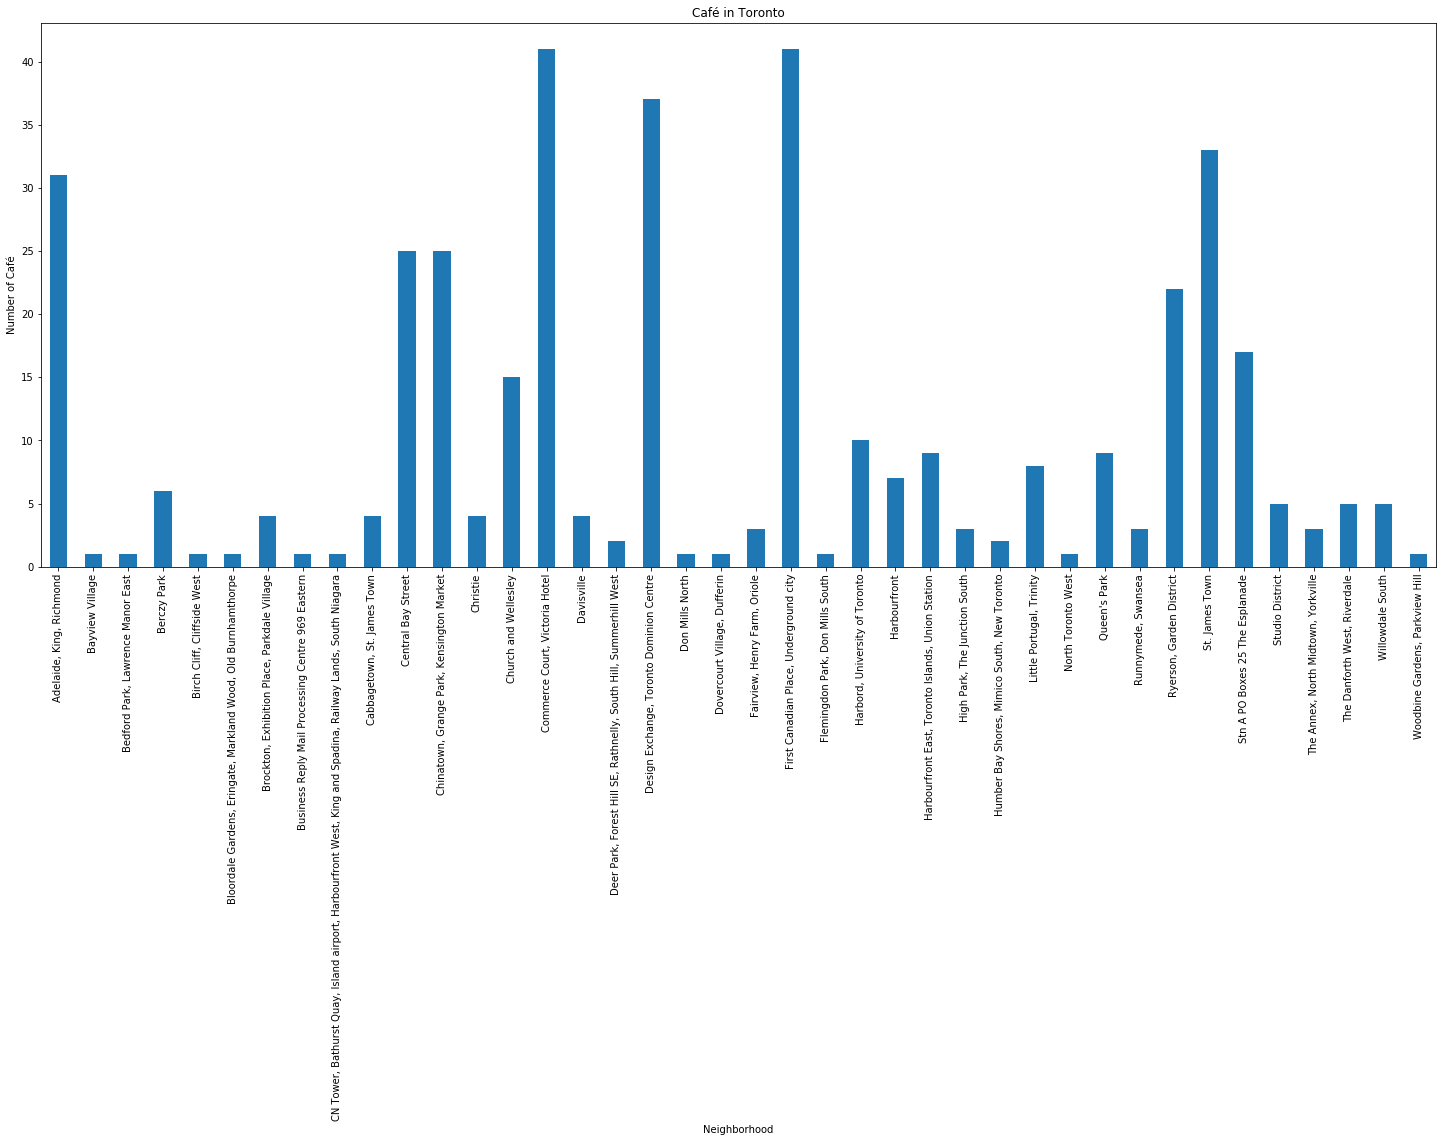

In [63]:
import matplotlib.pyplot as plt
cafe = toronto_venues[toronto_venues['Venue Category']=='Café'].groupby('Neighborhood').count()

cafe['Venue'].plot(kind='bar', figsize=(25, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Café') # add y-label to the plot
plt.title('Café in Toronto') # add title to the plot

plt.show()

#### For further analysis, select only the neighborhoods in which the café is located

In [83]:
selected_neighborhood = cafe.index
target_toronto_venues = toronto_venues_all[toronto_venues_all['Neighborhood'].isin(selected_neighborhood)]
target_toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,56,56,56,56,56,56
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",8,8,8,8,8,8
"Brockton, Exhibition Place, Parkdale Village",23,23,23,23,23,23
Business Reply Mail Processing Centre 969 Eastern,16,16,16,16,16,16
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16


#### One hot encoding

In [84]:
# one hot encoding
toronto_onehot = pd.get_dummies(target_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = target_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each categor

In [87]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.01,0.0,0.01
1,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00
2,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00
3,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.00,0.0,0.00
4,"Birch Cliff, Cliffside West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.00


In [171]:
for Neighborhood in toronto_grouped['Neighborhood']:
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == Neighborhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    max_freq=0
    for index,row in temp.iterrows():
        if row['venue']=='Café':
            freq=row['freq']
            #print(row['venue'], row['freq'])
            if freq>max_freq:
                max_freq=freq
                solution_district=Neighborhood

print("The biggest proportion of Café among other venues in a district in Toronto is {} % in {}.".format(int(max_freq*100),solution_district))

The biggest proportion of Café among other venues in a district in Toronto is 7 % in Woodbine Gardens, Parkview Hill.


In [95]:
toronto_grouped.shape

(40, 238)

In [96]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

----Adelaide, King, Richmond----
----Bayview Village----
----Bedford Park, Lawrence Manor East----
----Berczy Park----
----Birch Cliff, Cliffside West----
----Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe----
----Brockton, Exhibition Place, Parkdale Village----
----Business Reply Mail Processing Centre 969 Eastern----
----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
----Cabbagetown, St. James Town----
----Central Bay Street----
----Chinatown, Grange Park, Kensington Market----
----Christie----
----Church and Wellesley----
----Commerce Court, Victoria Hotel----
----Davisville----
----Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West----
----Design Exchange, Toronto Dominion Centre----
----Don Mills North----
----Dovercourt Village, Dufferin----
----Fairview, Henry Farm, Oriole----
----First Canadian Place, Underground city----
----Flemingdon Park, Don Mills South----
----Harbord, University

#### Create a data frame of the venues

Function to sort the venues in descending order.

In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood

In [98]:
import numpy as np

In [116]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Steakhouse,Café,Breakfast Spot,Restaurant,Cosmetics Shop,Thai Restaurant,Burger Joint,Bar,Bakery
1,Bayview Village,Japanese Restaurant,Chinese Restaurant,Bank,Café,Women's Store,Cupcake Shop,Donut Shop,Doner Restaurant,Dog Run,Discount Store
2,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Sandwich Place,Butcher,Pharmacy,Restaurant,Indian Restaurant,Liquor Store,Pub
3,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Steakhouse,Café,Seafood Restaurant,Farmers Market,Bakery,Beer Bar,Bistro
4,"Birch Cliff, Cliffside West",Skating Rink,General Entertainment,College Stadium,Café,Cuban Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner


### Clustering similar neighborhoods together using k - means clustering

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [118]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
range_n_clusters = list (range(2,20)) #Max n cluster to test

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(toronto_grouped_clustering)
    centers = clusterer.cluster_centers_

    score = silhouette_score(toronto_grouped_clustering, preds, metric='euclidean')
    print("For n cluster {} silhouette score is {}".format(n_clusters, score))

For n cluster 2 silhouette score is 0.42446487690561413
For n cluster 3 silhouette score is 0.42079402361401097
For n cluster 4 silhouette score is 0.03944452235468696
For n cluster 5 silhouette score is 0.19924552702042103
For n cluster 6 silhouette score is 0.022173841113918402
For n cluster 7 silhouette score is 0.1735281719627967
For n cluster 8 silhouette score is 0.19032640487748723
For n cluster 9 silhouette score is 0.13089760818199178
For n cluster 10 silhouette score is 0.13795776984956326
For n cluster 11 silhouette score is 0.07221936698364798
For n cluster 12 silhouette score is 0.08549110353717042
For n cluster 13 silhouette score is 0.12411776189439305
For n cluster 14 silhouette score is 0.1512226413840429
For n cluster 15 silhouette score is 0.08602421517366461
For n cluster 16 silhouette score is 0.05287797719069489
For n cluster 17 silhouette score is 0.06424388601993916
For n cluster 18 silhouette score is 0.03338011375804864
For n cluster 19 silhouette score is 0.0

In [152]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]

array([1, 4, 1, 1, 0, 1, 3, 1, 1, 1])

In [153]:
t_data = toronto_data[toronto_data['Neighborhood'].isin(selected_neighborhood)]
t_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
13,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
17,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",43.643515,-79.577201
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [154]:
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = t_data
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Café,Park,Mexican Restaurant,Breakfast Spot,Restaurant,Chocolate Shop,Historic Site
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,1,Coffee Shop,Gym,Park,Music Venue,Seafood Restaurant,Sandwich Place,Salad Place,Restaurant,Burger Joint,Burrito Place
5,M9A,Queen's Park,Queen's Park,43.667856,-79.532242,1,Coffee Shop,Gym,Park,Music Venue,Seafood Restaurant,Sandwich Place,Salad Place,Restaurant,Burger Joint,Burrito Place
7,M3B,North York,Don Mills North,43.745906,-79.352188,2,Café,Japanese Restaurant,Basketball Court,Gym / Fitness Center,Caribbean Restaurant,Women's Store,Dim Sum Restaurant,Deli / Bodega,Department Store,Dessert Shop
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937,3,Pizza Place,Fast Food Restaurant,Pharmacy,Bus Line,Café,Athletics & Sports,Intersection,Gym / Fitness Center,Bank,Pet Store
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,1,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Bakery,Pizza Place,Bookstore,Restaurant,Diner
13,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,1,Beer Store,Gym,Asian Restaurant,Coffee Shop,Bike Shop,Italian Restaurant,Sandwich Place,Supermarket,Café,Dim Sum Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,American Restaurant,Clothing Store,Bakery,Breakfast Spot,Cosmetics Shop,Italian Restaurant,Beer Bar
17,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",43.643515,-79.577201,1,Beer Store,Shopping Plaza,Pizza Place,Café,Convenience Store,Cosmetics Shop,Liquor Store,Coffee Shop,Furniture / Home Store,Garden Center
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Cheese Shop,Steakhouse,Café,Seafood Restaurant,Farmers Market,Bakery,Beer Bar,Bistro


#### Visualize the clusters

In [155]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [172]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## Analysis <a name="analysis"></a>
Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

##### Examine Cluster 0

In [157]:
k0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]
k0

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,M1N,0,Skating Rink,General Entertainment,College Stadium,Café,Cuban Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner


##### Examine Cluster 1

In [173]:
k1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
k1.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,1,Coffee Shop,Bakery,Pub,Café,Park,Mexican Restaurant,Breakfast Spot,Restaurant,Chocolate Shop,Historic Site
4,Downtown Toronto,1,Coffee Shop,Gym,Park,Music Venue,Seafood Restaurant,Sandwich Place,Salad Place,Restaurant,Burger Joint,Burrito Place
5,Queen's Park,1,Coffee Shop,Gym,Park,Music Venue,Seafood Restaurant,Sandwich Place,Salad Place,Restaurant,Burger Joint,Burrito Place
9,Downtown Toronto,1,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Bakery,Pizza Place,Bookstore,Restaurant,Diner
13,North York,1,Beer Store,Gym,Asian Restaurant,Coffee Shop,Bike Shop,Italian Restaurant,Sandwich Place,Supermarket,Café,Dim Sum Restaurant


##### Examine Cluster 2

In [159]:
k2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
k2

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,North York,2,Café,Japanese Restaurant,Basketball Court,Gym / Fitness Center,Caribbean Restaurant,Women's Store,Dim Sum Restaurant,Deli / Bodega,Department Store,Dessert Shop


##### Examine Cluster 3

In [174]:
k3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
k3.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,East York,3,Pizza Place,Fast Food Restaurant,Pharmacy,Bus Line,Café,Athletics & Sports,Intersection,Gym / Fitness Center,Bank,Pet Store
25,Downtown Toronto,3,Grocery Store,Café,Park,Athletics & Sports,Nightclub,Candy Store,Restaurant,Diner,Italian Restaurant,Bank
31,West Toronto,3,Pharmacy,Bakery,Supermarket,Bar,Fast Food Restaurant,Café,Middle Eastern Restaurant,Recording Studio,Gym / Fitness Center,Grocery Store
43,West Toronto,3,Café,Coffee Shop,Breakfast Spot,Nightclub,Convenience Store,Italian Restaurant,Intersection,Restaurant,Burrito Place,Bar
54,East Toronto,3,Café,Coffee Shop,Brewery,American Restaurant,Italian Restaurant,Gastropub,Bakery,Stationery Store,Diner,Bank


##### Examine Cluster 4

In [161]:
k4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
k4

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,North York,4,Japanese Restaurant,Chinese Restaurant,Bank,Café,Women's Store,Cupcake Shop,Donut Shop,Doner Restaurant,Dog Run,Discount Store


In [162]:
print("k0 shape = ",k0.shape)
print("k1 shape = ",k1.shape)
print("k2 shape = ",k2.shape)
print("k3 shape = ",k3.shape)
print("k4 shape = ",k4.shape)


k0 shape =  (1, 12)
k1 shape =  (30, 12)
k2 shape =  (1, 12)
k3 shape =  (8, 12)
k4 shape =  (1, 12)


## Results and Discussion <a name="results"></a>

The purpose of my experiment was to point out the right neighborhood to open a café in Toronto. Based on the experiments, districts where cafés already exist were selected at the beginning. There are 40 of them, and then, to broaden the scope of clustering, all the popular places in the districts where the café already exists were found. It was indicated that "The biggest proportion of Café among other venues in a district in Toronto is 7 % in Woodbine Gardens, Parkview Hill." In some cases, cafés have not been identified as a popular place at all.

However, taking into account the grouping performed, I can recommend cluster 0 and 4 because there the cafes occupy the farthest place according to popularity. We must remember that in this experiment the distance from the centre was not taken into account. The investor can of course make a different choice, because the data is already prepared.

## Conclusion  <a name="conclusion"></a>
Different applications of this analysis are available based on a different methodology and possibly different data sources. The stakeholder problem has been resolved. This project helps the investor to better understand the area in relation to the most common places in the area. It is always helpful to use technology to be one step ahead, i.e. learn more about places before opening a new coffee shop in the district. The future of this project involves considering other factors, such as the cost of living in the areas concerned, in order to draw up a short list of neighbourhoods based on a predefined budget.